# Entrega 2

## Ejercicio 1

### a. ¿Que situacion se representa con una variable aleatoria geometrica?

Usamos una variable aleatoria geométrica para modelar el número de intentos necesarios hasta llegar al primer éxito en ensayos de Bernoulli independientes y con probabilidad constante de éxito $\theta$

Algunos ejemplos son:
- Lanzamientos de una moneda
- Control de Calidad
- y muchos mas

### b. Derivar la distribucion posterior para $\theta$ suponiendo que se observó Y = y. Identificar la distribución encontrada y sus parámetros.

Sabemos:
1. Prior ∼ Beta(a, b)
2. Likelihood: $P(Y = y∣\theta) = \theta(1 - \theta)^{y-1}$
3. Posterior: Multiplicamos el Prior por la Likelihood y normalizamos:
    - $\theta ∣ Y = y ∼ Beta(a + 1, b + y - 1)$

### c. ¿El modelo Beta es un prior conjugado de la Geométrica?

Si, pues el Prior y el Posterior pertenecen al mismo tipo de distribuciones (Beta)

---

Bis: Ejemplo (para mi) para fijar mejor las ideas:

Supongamos un juego de donde se debe lanzar un dado y se gana al sacar un "6". Se quiere estimar la probabilidad $\theta$ de ganar en un solo lanzamiento. 

Supongo que es dificil sacar ese "6", pero no estoy seguro y quiero actualizar mi creencia luego de cada lanzamiento.

Entonces:
- Variable aleatoria Y: Numero de lanzamientos hasta sacar el "6".
- Distr Geometrica: $P(Y = y∣\theta) = \theta(1 - \theta)^{y-1}$
- Prior Beta: Empezamos de forma pesimista sobre sacar un "6". a = 2, b = 10.

Observacion:

Imagino que juego el juego, y el primer "6" aparece en mi 5to lanzamiento. Y = 5.

Actualizacion:

- Likelihood: Y = 5 con lo que:  $\theta (1 - \theta)^{4}$
- Posterior: Posterior $\alpha$ Prior * Likelihood = Beta(2, 10) * $\theta (1 - \theta)^{4}$
        - Es decir: Post $\alpha$ $\theta^{2 + 1}(1 - \theta)^{10 + 4 - 1}$ = $\theta^{3}(1 - \theta)^{13}$

Esto significa que el Post tambien es Beta. Pues Post = Beta(3, 13)

---

## Ejercicio 2

Elijo como modelo de Regresion Lineal el precio de la comida y la propina dejada.

Obtenemos nuestros datos:

Cambiar modelo Gamma a Normal(mu, sigma**2):

Generar 2 Normales para los priors B_0 y B_1.
Generar 1 Exp para sigma.

- B_0 -> N(3, 3) -> En un plato de 20usd (eje x = 0) propongo 3usd de propina con un rango de +-3usd
- B_1 -> N(0.1, 0.5)  -> Digo que dejo 10% de propina con un rango de +-0.5usd
- sigma -> Exp(3/2)  -> Cuanto se expanden mis propinas respecto a la comida.

Para hacer:
1. Grafico para B0, B1, Sigma (que son los priors)
2. Calcular likelihood: L(datos| tita) = P(Yi) -> N(beta0 + beta1 * x, sigma**2) , Likelihood es la distr de densidad de mis priors.
3. Eliminar abs del mcmc (ver #)
4. Ver la probabilidad de aceptacion

Recordar:
Post(datos, tita) = L(datos| tita) * Prior(tita), donde tita = {beta0, beta1, sigma}


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import seaborn.objects as so
import matplotlib.pyplot as plt

from scipy.stats import expon, norm   # Medidas de desempeño
import pymc as pm

WARNING (pytensor.configdefaults): g++ not available, if using conda: `conda install m2w64-toolchain`
WARNING (pytensor.configdefaults): g++ not detected!  PyTensor will be unable to compile C-implementations and will default to Python. Performance may be severely degraded. To remove this warning, set PyTensor flags cxx to an empty string.
WARNING (pytensor.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [5]:
datos = sns.load_dataset("tips")

# Para no perder el contexto de los tips, vamos a quedarnos con los platos >= 20 usd
datos["total_bill"] = datos["total_bill"] - 20
datos_filtrados = datos[datos["total_bill"] >= 0]
datos_filtrados

,total_bill,tip,sex,smoker,day,time,size
2,1.01,3.50,Male,No,Sun,Dinner,3
3,3.68,3.31,Male,No,Sun,Dinner,2
4,4.59,3.61,Female,No,Sun,Dinner,4
5,5.29,4.71,Male,No,Sun,Dinner,4
7,6.88,3.12,Male,No,Sun,Dinner,4
...,...,...,...,...,...,...,...
237,12.83,1.17,Male,Yes,Sat,Dinner,2
238,15.83,4.67,Female,No,Sat,Dinner,3
239,9.03,5.92,Male,No,Sat,Dinner,3
240,7.18,2.00,Female,Yes,Sat,Dinner,2


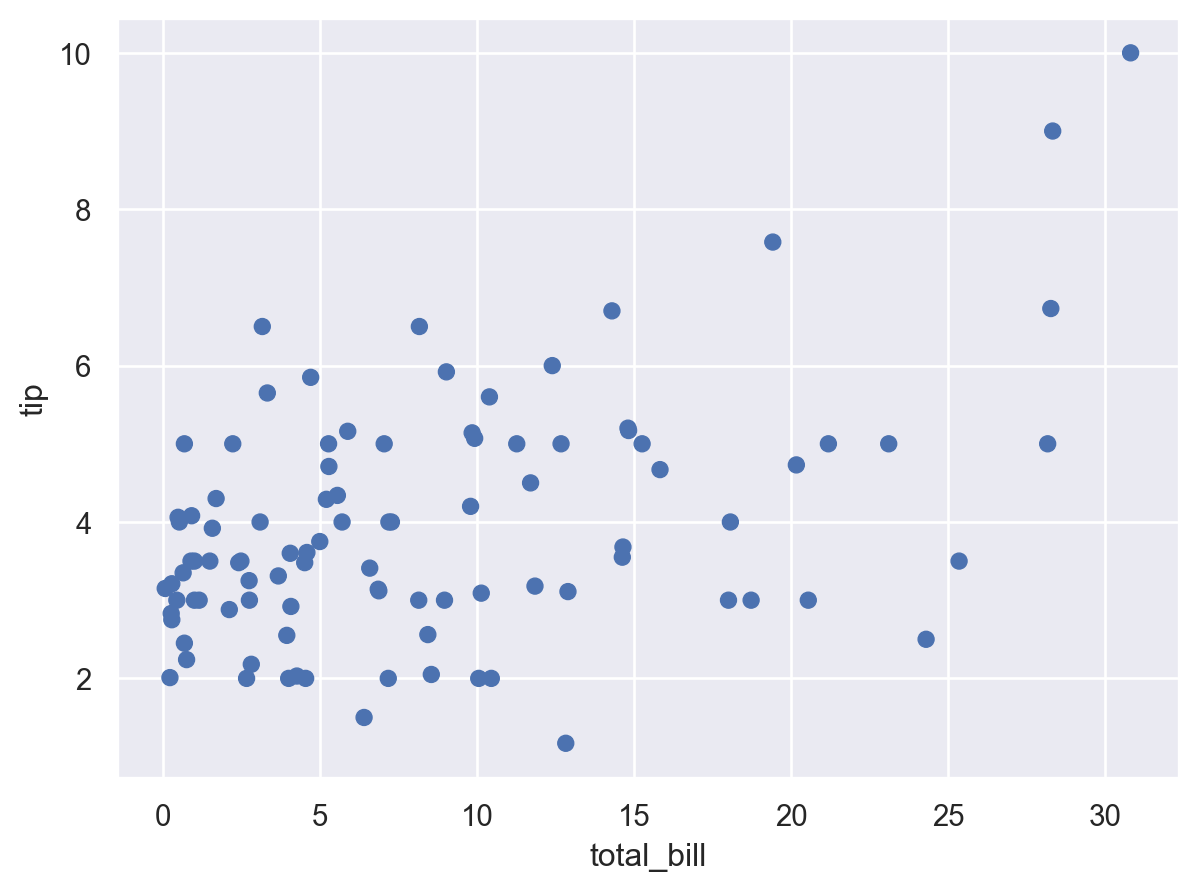

In [6]:
(
    so.Plot(data=datos_filtrados, x="total_bill", y="tip")
    .add(so.Dot())
)


### a. Proponer priors para $\beta_0$, $\beta_1$ y $\sigma $

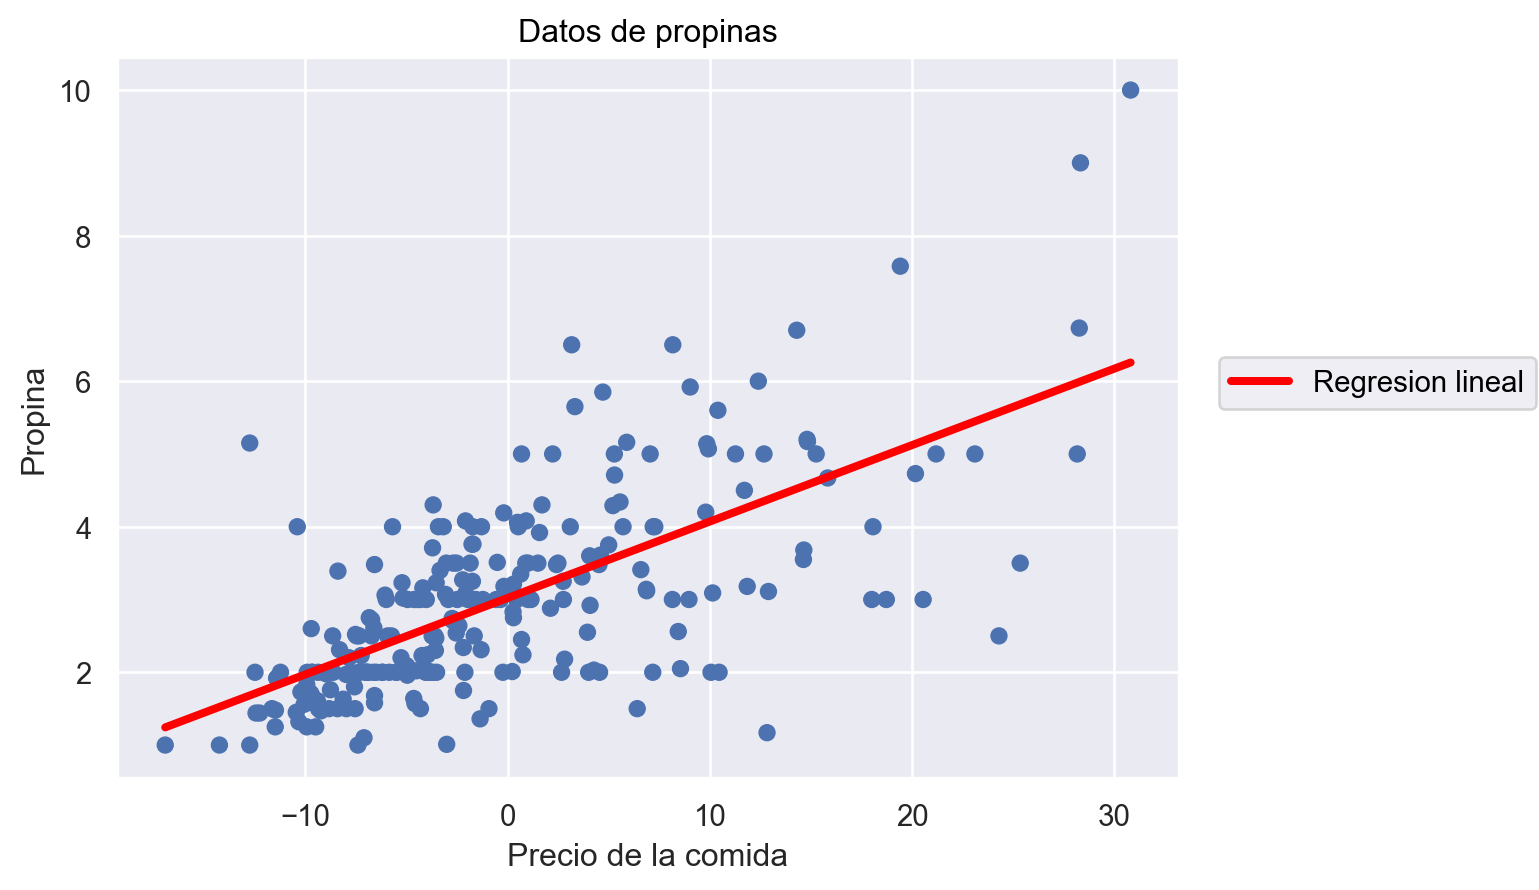

In [7]:
(
    so.Plot(data=datos, x="total_bill", y="tip")
    .add(so.Dot())
    .add(so.Line(color="red", linewidth=3), so.PolyFit(1), label="Regresion lineal")  
    .label(title="Datos de propinas", x="Precio de la comida", y="Propina")   
)


Uno pensaria que cuanto mas cara la comida, mayor es la propina (el conocido 10%)

Entonces decido elegir un caso individual:
- Una comida que cueste 20 usd.
- Su propina debe rondar por los 2 usd.
- Se deja un minimo de propina de 1usd sin importar el costo de la comida.


Queremos modelar la relacion de esta manera:
$Y = \beta_1 * X + \beta_1 $

Donde:
- **Y** es la propina
- **X** es el precio de la comida
- **$\beta_1$** es el parámetro que indica la proporción de la propina respecto al precio de la comida (10%).
- **$\beta_0$** es el intercept, la propina base dejada (1usd).

Entonces defino nuestras distribuciones de este modo:
- $\beta_0 ∼ Normal(1, 1^2)$ , para que cuando X = 0, la propina se estandarice en 1usd
- $\beta_1 ∼ Normal(0.1, 0.01^2)$
- $\sigma ∼ Exp(1)$






In [37]:
# Priors para beta_0, beta_1, sigma
def prior_beta_0(beta_0):
    return norm.logpdf(beta_0, 1, 1)

def prior_beta_1(beta_1):
    return norm.logpdf(beta_1, 0.1, 0.01)

def prior_sigma(sigma):
    return expon.logpdf(sigma, scale=1)


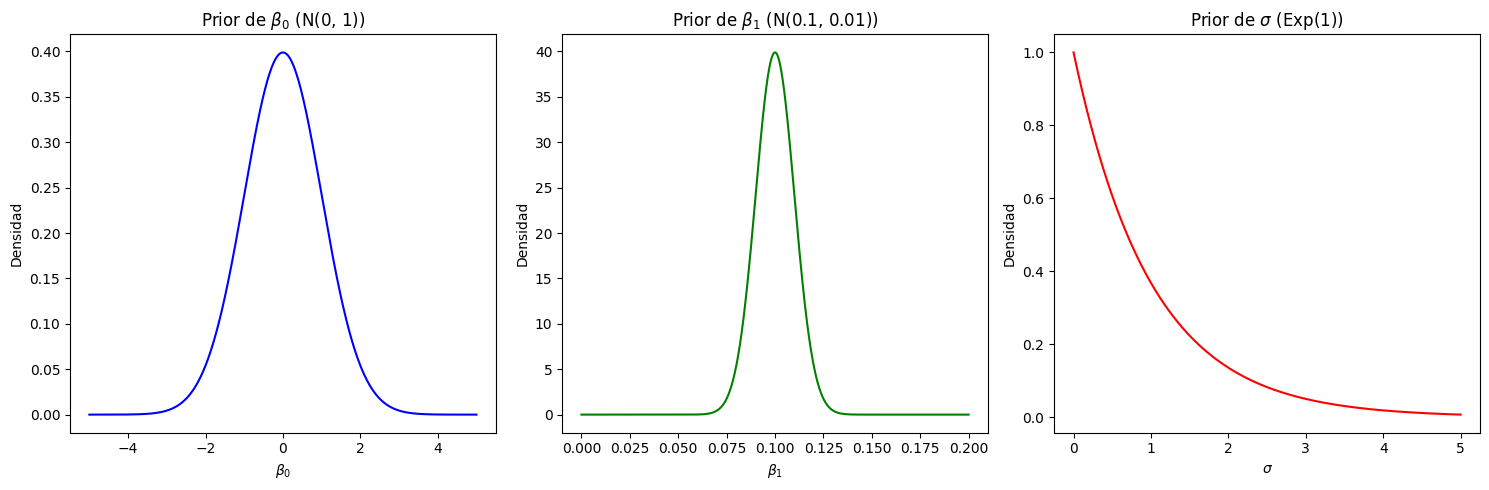

In [38]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm, expon

# Definir los rangos de los parámetros para graficar
beta_0_values = np.linspace(-5, 5, 1000)  # Valores para beta_0
beta_1_values = np.linspace(0, 0.2, 1000)  # Valores para beta_1
sigma_values = np.linspace(0, 5, 1000)  # Valores para sigma

# Calcular las densidades de los priors
prior_beta_0_density = norm.pdf(beta_0_values, 0, 1)  # Prior para beta_0 (N(0, 1))
prior_beta_1_density = norm.pdf(beta_1_values, 0.1, 0.01)  # Prior para beta_1 (N(0.1, 0.01))
prior_sigma_density = expon.pdf(sigma_values, scale=1)  # Prior para sigma (Exponencial)

# Graficar los priors
plt.figure(figsize=(15, 5))

# Gráfico de prior para beta_0
plt.subplot(1, 3, 1)
plt.plot(beta_0_values, prior_beta_0_density, color='blue')
plt.title("Prior de $\\beta_0$ (N(0, 1))")
plt.xlabel("$\\beta_0$")
plt.ylabel("Densidad")

# Gráfico de prior para beta_1
plt.subplot(1, 3, 2)
plt.plot(beta_1_values, prior_beta_1_density, color='green')
plt.title("Prior de $\\beta_1$ (N(0.1, 0.01))")
plt.xlabel("$\\beta_1$")
plt.ylabel("Densidad")

# Gráfico de prior para sigma
plt.subplot(1, 3, 3)
plt.plot(sigma_values, prior_sigma_density, color='red')
plt.title("Prior de $\\sigma$ (Exp(1))")
plt.xlabel("$\\sigma$")
plt.ylabel("Densidad")

plt.tight_layout()
plt.show()

### b. Escribir la Likelihood de los datos de forma analitica en funcion de los parametros.

In [39]:
# Función de likelihood: L(datos | beta_0, beta_1, sigma)
def log_likelihood(beta_0, beta_1, sigma, X, Y):
    mu = beta_0 + beta_1 * X 
    return np.sum(norm.logpdf(Y, mu, sigma)) 

### c. Implementar MCMC y generar 5000 samples del posterior sin descontar el tramo inicial de la cadena (burn = 0).

In [40]:
# Función para generar nuevas propuestas para beta_0, beta_1 y sigma
# Esto genera nuevos valores de los parametros para comparar con los actuales y decidir si aceptar o rechazar
def propuesta(posterior_actual, scale=0.05):
    return posterior_actual + norm.rvs(scale=scale)

In [41]:
def mcmc(datos_X, datos_Y, beta_0_inicial, beta_1_inicial, sigma_inicial, iteraciones=5000, sigma_beta_0=0.1, sigma_beta_1=0.005, sigma_sigma=0.05):
    # Inicializamos las cadenas de beta_0, beta_1, y sigma
    cadena_beta_0 = [beta_0_inicial]
    cadena_beta_1 = [beta_1_inicial]
    cadena_sigma = [sigma_inicial]
    
    # Iteramos
    for i in range(iteraciones):
        # Proponemos nuevos valores para beta_0, beta_1, y sigma
        nuevo_beta_0 = propuesta(cadena_beta_0[-1], sigma_beta_0)
        nuevo_beta_1 = propuesta(cadena_beta_1[-1], sigma_beta_1)
        nuevo_sigma = propuesta(cadena_sigma[-1], sigma_sigma)  # Aseguramos que sigma sea positivo
        
        # Calculamos la log-verosimilitud actual y la nueva
        log_likelihood_actual = log_likelihood(cadena_beta_0[-1], cadena_beta_1[-1], cadena_sigma[-1], datos_X, datos_Y)
        log_likelihood_nuevo = log_likelihood(nuevo_beta_0, nuevo_beta_1, nuevo_sigma, datos_X, datos_Y)

        # Calculamos los priors actuales y nuevos
        prior_actual = prior_beta_0(cadena_beta_0[-1]) + prior_beta_1(cadena_beta_1[-1]) + prior_sigma(cadena_sigma[-1])
        prior_nuevo = prior_beta_0(nuevo_beta_0) + prior_beta_1(nuevo_beta_1) + prior_sigma(nuevo_sigma)

        # Log Posterior actual y nuevo
        log_posterior_actual = log_likelihood_actual + prior_actual
        log_posterior_nuevo = log_likelihood_nuevo + prior_nuevo

        # Aceptamos o rechazamos la propuesta
        if log_posterior_nuevo > log_posterior_actual:
            cadena_beta_0.append(nuevo_beta_0)
            cadena_beta_1.append(nuevo_beta_1)
            cadena_sigma.append(nuevo_sigma)
        else:
            probabilidad_aceptacion = np.exp(log_posterior_nuevo - log_posterior_actual)
            if np.random.rand() < probabilidad_aceptacion:
                cadena_beta_0.append(nuevo_beta_0)
                cadena_beta_1.append(nuevo_beta_1)
                cadena_sigma.append(nuevo_sigma)
            else:
                cadena_beta_0.append(cadena_beta_0[-1])
                cadena_beta_1.append(cadena_beta_1[-1])
                cadena_sigma.append(cadena_sigma[-1])

    return np.array(cadena_beta_0), np.array(cadena_beta_1), np.array(cadena_sigma)


In [42]:
# Extraer los datos de las columnas "total_bill" y "tip"
tips_hipotesis = datos_filtrados["tip"].values
bills_hipotesis = datos_filtrados["total_bill"].values

# Valores iniciales para los parámetros
beta_0_inicial = 0  # Intercepto inicial
beta_1_inicial = 0.1  # Pendiente inicial (hipótesis de 10%)
sigma_inicial = 1  # Desviación estándar inicial

# Ejecutar el MCMC
cadena_beta_0, cadena_beta_1, cadena_sigma = mcmc(tips_hipotesis, bills_hipotesis, beta_0_inicial, beta_1_inicial, sigma_inicial, iteraciones = 5000)

In [43]:
# Mostrar los últimos valores de la cadena
print("Últimos valores de la cadena:")
print(f"beta_0: {cadena_beta_0[-5:]}")
print(f"beta_1: {cadena_beta_1[-5:]}")
print(f"sigma: {cadena_sigma[-5:]}")

Últimos valores de la cadena:
beta_0: [5.8075396  5.87479473 5.78484522 5.54091097 5.54091097]
beta_1: [0.09011704 0.09074804 0.09286815 0.09673407 0.09673407]
sigma: [7.22804844 7.24714652 7.22484622 7.13744313 7.13744313]


### d. Graficar la cadena resultante. ¿Parece haber convergido?

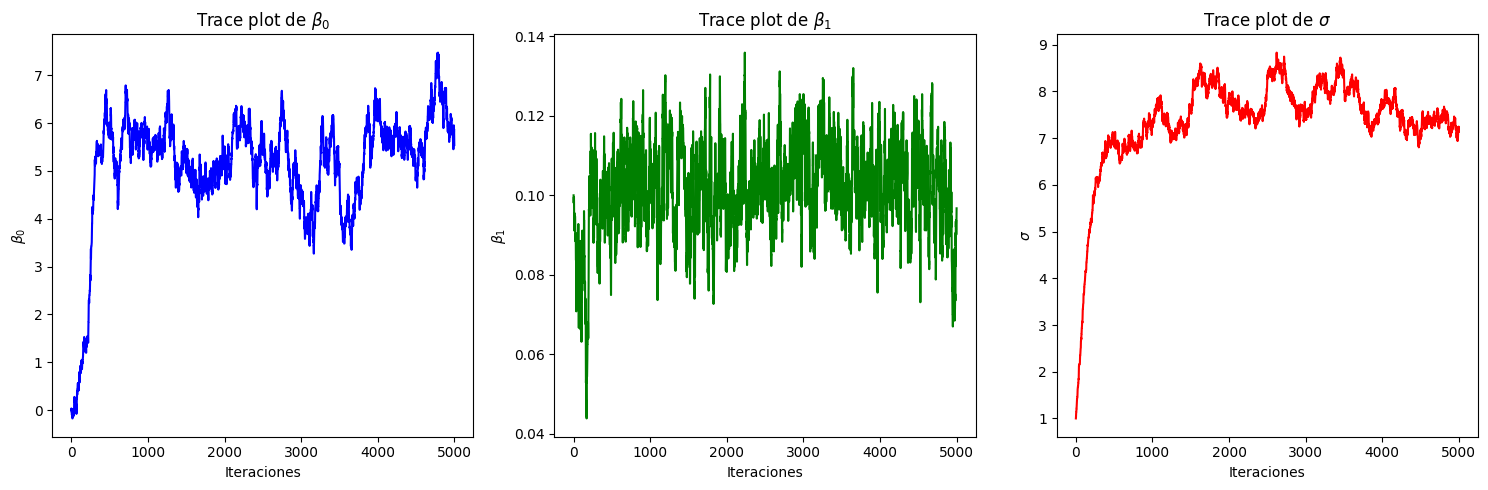

In [44]:
# Supongamos que ya tienes las cadenas generadas del MCMC para beta_0, beta_1, y sigma

# Crear las gráficas de trace plot
plt.figure(figsize=(15, 5))

# Trace plot para beta_0
plt.subplot(1, 3, 1)
plt.plot(cadena_beta_0, color='blue')
plt.title('Trace plot de $\\beta_0$')
plt.xlabel('Iteraciones')
plt.ylabel('$\\beta_0$')

# Trace plot para beta_1
plt.subplot(1, 3, 2)
plt.plot(cadena_beta_1, color='green')
plt.title('Trace plot de $\\beta_1$')
plt.xlabel('Iteraciones')
plt.ylabel('$\\beta_1$')

# Trace plot para sigma
plt.subplot(1, 3, 3)
plt.plot(cadena_sigma, color='red')
plt.title('Trace plot de $\\sigma$')
plt.xlabel('Iteraciones')
plt.ylabel('$\\sigma$')

# Mostrar los gráficos
plt.tight_layout()
plt.show()


Viendo el grafico, podemos concluir que $\alpha$ y $\beta$ parecen haber convergido hasta mucho antes de las 5mil samples.

Podriamos usar burn = 2000 y obtendriamos resultados similares.

### e. Repetir el inciso c. y d. para 3 cadenas paralelas. Graficarlas superpuestas con colores distintos. ¿Cuantos samples tarda en llegar a estado de equilibrio?

Eligo valores iniciales de $\beta_1$, $\beta_1$ y $\sigma$ al azar.

In [45]:
beta0_1 = 10
beta1_1 = 5
sigma_1 = 3

cadenas_beta0_1 = []
cadenas_beta1_1 = []
cadenas_sigma_1 = []

beta0_2 = 20
beta1_2 = 10
sigma_2 = 9

cadenas_beta0_2 = []
cadenas_beta1_2 = []
cadenas_sigma_2 = []

beta0_3 = 30
beta1_3 = 15
sigma_3 = 15

cadenas_beta0_3 = []
cadenas_beta1_3 = []
cadenas_sigma_3 = []

In [46]:
cadenas_beta0_1, cadenas_beta1_1, cadenas_sigma_1 = mcmc(tips_hipotesis, bills_hipotesis, beta0_1, beta1_1, sigma_1, iteraciones = 10000)
cadenas_beta0_2, cadenas_beta1_2, cadenas_sigma_2 = mcmc(tips_hipotesis, bills_hipotesis, beta0_2, beta1_2, sigma_2, iteraciones = 10000)
cadenas_beta0_3, cadenas_beta1_3, cadenas_sigma_3 = mcmc(tips_hipotesis, bills_hipotesis, beta0_3, beta1_3, sigma_3, iteraciones = 10000)

In [47]:
# Para visualizar algo más tangible.
print("Últimos valores de la cadena 1:")
print(f"beta 0: {cadenas_beta0_1[-5:]}")
print(f"beta 1: {cadenas_beta1_1[-5:]} ")
print(f"sigma: {cadenas_sigma_1[-5:]} \n")

print("Últimos valores de la cadena 2:")
print(f"beta 0: {cadenas_beta0_2[-5:]}")
print(f"beta 1: {cadenas_beta1_2[-5:]} ")
print(f"sigma: {cadenas_sigma_2[-5:]} \n")

print("Últimos valores de la cadena 3:")
print(f"beta 0: {cadenas_beta0_3[-5:]}")
print(f"beta 1: {cadenas_beta1_3[-5:]} ")
print(f"sigma: {cadenas_sigma_3[-5:]} \n")

Últimos valores de la cadena 1:
beta 0: [4.09181043 4.15903543 4.39700647 4.390075   4.35263598]
beta 1: [0.09506103 0.09697796 0.09487303 0.0969205  0.09550109] 
sigma: [7.54397721 7.53781843 7.55706489 7.5732502  7.47457423] 

Últimos valores de la cadena 2:
beta 0: [3.90342613 3.93566219 4.05367921 4.1448753  4.14623437]
beta 1: [0.109387   0.1058292  0.1086008  0.11099422 0.10934039] 
sigma: [7.82964612 7.71998994 7.66522563 7.61218208 7.68879726] 

Últimos valores de la cadena 3:
beta 0: [4.81338563 5.01809008 5.16108223 5.27570124 5.24380157]
beta 1: [0.10426813 0.10764453 0.10638688 0.10970368 0.11086607] 
sigma: [7.85501586 7.79176429 7.70051965 7.75175998 7.75311605] 



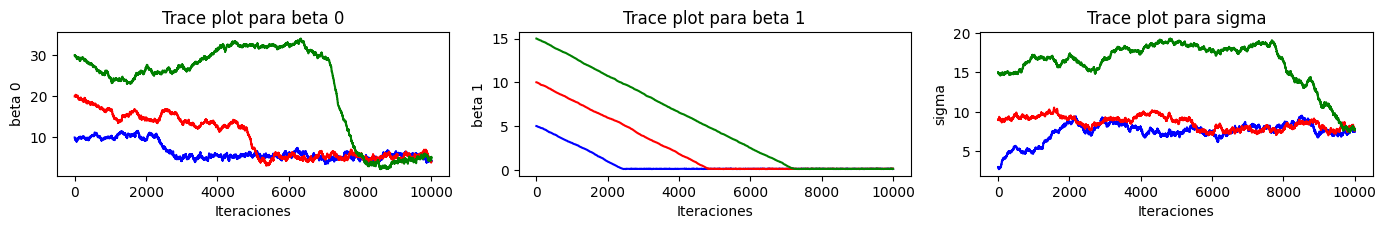

<Figure size 1400x600 with 0 Axes>

In [48]:
# Asumimos que ya tenemos las cadenas "cadena_alpha" y "cadena_beta" después de ejecutar el MCMC

# Trazas de la cadena para beta 0, beta 1 y sigma
plt.figure(figsize=(14, 6))

# beta 0
plt.subplot(3, 3, 1)
plt.plot(cadenas_beta0_1, color="blue")
plt.plot(cadenas_beta0_2, color="red")
plt.plot(cadenas_beta0_3, color="green")
plt.title("Trace plot para beta 0")
plt.xlabel("Iteraciones")
plt.ylabel("beta 0")

# beta 1
plt.subplot(3, 3, 2)
plt.plot(cadenas_beta1_1, color="blue")
plt.plot(cadenas_beta1_2, color="red")
plt.plot(cadenas_beta1_3, color="green")
plt.title("Trace plot para beta 1")
plt.xlabel("Iteraciones")
plt.ylabel("beta 1")

# sigma 
plt.subplot(3, 3, 3)
plt.plot(cadenas_sigma_1, color="blue")
plt.plot(cadenas_sigma_2, color="red")
plt.plot(cadenas_sigma_3, color="green")
plt.title("Trace plot para sigma")
plt.xlabel("Iteraciones")
plt.ylabel("sigma")

plt.tight_layout()
plt.show()


plt.figure(figsize=(14, 6))
plt.tight_layout()
plt.show()



Pareciera ser que luego de alrededor de 9500 samples llegamos al estado de equilibrio.

### f. Elija al azar 100 samples del posterior y grafique las 100 rectas correspondientes superpuestas a los datos.

Vamos a tomar 100 samples random del posterior, pero para que sean mas optimas. Elegiremos las que no se encuentren dentro del burn (es decir que no esten dentro de las 9500 iteraciones).

In [49]:
"""
Recordemos que ya calculamos el MCMC de esta distribucion anteriormente.

beta_0 = 20
beta_1 = 5
sigma = 10

cadenas_alpha_2 = []
cadenas_beta_2 = []

cadenas_alpha_2, cadenas_beta_2 = mcmc(tips_hipotesis, alpha_2, beta_2, iteraciones)
"""

burn = 9500

# Eliminamos los 1000 primeros
beta0_post = cadenas_beta0_2[burn:]
beta1_post= cadenas_beta1_2[burn:]
sigma_post = cadenas_sigma_2[burn:]

# Elegimos de forma random 100 samples dentro del burn
random_samples = np.random.choice(len(beta0_post), size=100, replace=False)

# Obtenemos las muestras
muestras_beta_0= beta0_post[np.random.choice(len(beta0_post), size=100, replace=False)]
muestras_beta_1 = beta1_post[np.random.choice(len(beta1_post), size=100, replace=False)]
muestras_sigma = sigma_post[np.random.choice(len(sigma_post), size=100, replace=False)]



In [50]:
# Printeamos a ver si tiene sentido:
print("Últimos valores de las muestras:")
print(f"beta 0: {muestras_beta_0[-5:]}")
print(f"beta 1: {muestras_beta_1[-5:]}")
print(f"beta 1: {muestras_sigma[-5:]} \n")
print("Tamaño:")
print("beta 0:", len(muestras_beta_0))
print("beta 1:", len(muestras_beta_1))
print("sigma: ", len(muestras_sigma))


Últimos valores de las muestras:
beta 0: [6.01891859 4.68508283 4.53483863 4.32852437 5.86444379]
beta 1: [0.07428581 0.10165296 0.11695816 0.0952417  0.12575244]
beta 1: [8.32290648 7.68590576 8.1990282  7.88293232 8.58688469] 

Tamaño:
beta 0: 100
beta 1: 100
sigma:  100


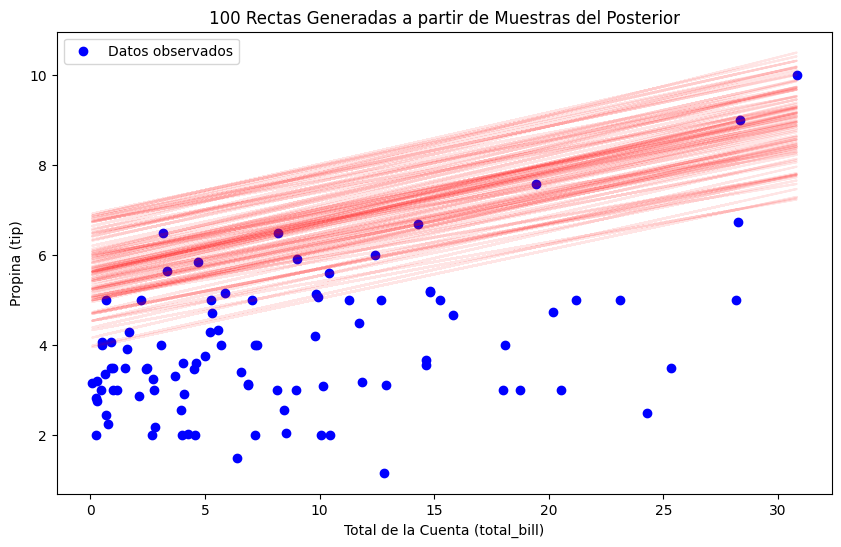

In [51]:
import numpy as np
import matplotlib.pyplot as plt

# Suponemos que ya tenemos las muestras tomadas del posterior
# muestras_beta_0, muestras_beta_1, y muestras_sigma



# Graficamos los datos observados
plt.figure(figsize=(10, 6))
plt.scatter(bills_hipotesis, tips_hipotesis, color='blue', label='Datos observados')

# Generamos las 100 rectas a partir de las muestras del posterior
for i in range(100):
    beta_0 = muestras_beta_0[i]
    beta_1 = muestras_beta_1[i]
    
    # Generar la recta predicha: tip = beta_0 + beta_1 * total_bill
    tip_predicho = beta_0 + beta_1 * bills_hipotesis
    plt.plot(bills_hipotesis, tip_predicho, color='red', alpha=0.1)  # Baja opacidad para no saturar el gráfico

# Configuramos el gráfico
plt.title('100 Rectas Generadas a partir de Muestras del Posterior')
plt.xlabel('Total de la Cuenta (total_bill)')
plt.ylabel('Propina (tip)')
plt.legend()
plt.show()


### g. Genere una distribucion posterior predictive para Y con algun X fijo. Utilicela para responder alguna pregunta relevante a sus datos.

Generamos una distribucion posterior predictive de propinas dada una comida de 30usd.

Vamos a calcular la proporcion de muestras de la distribucion donde la propina es mayor a 5usd.

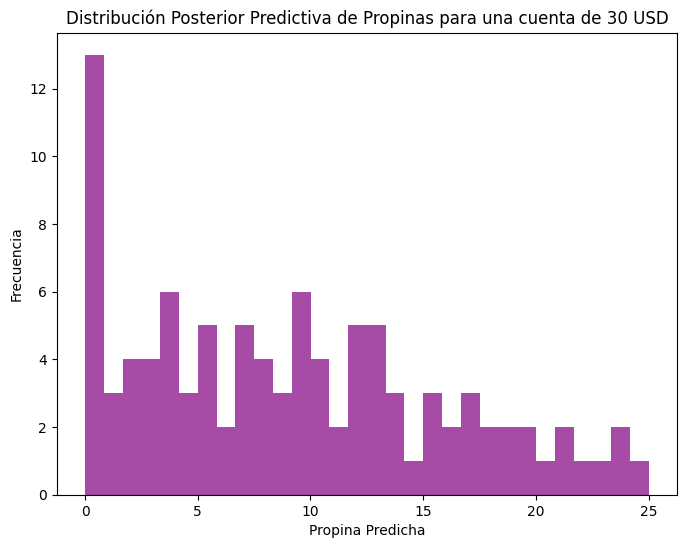

La probabilidad de que la propina sea mayor a 5 USD para una cuenta de 30 USD es: 0.67


In [55]:
import numpy as np
import matplotlib.pyplot as plt

# Comida de 30 USD
comida = 30

# Generar la distribución posterior predictiva usando las muestras de beta_0, beta_1 y sigma
# Sigma afecta la variabilidad de la propina (por eso añadimos ruido).
propinas_predichas = []

for i in range(len(muestras_beta_0)):
    # Para cada muestra, calculamos la propina predicha incluyendo el término de error sigma
    beta_0 = muestras_beta_0[i]
    beta_1 = muestras_beta_1[i]
    sigma = muestras_sigma[i]
    
    # Calculamos la propina con ruido (sigma)
    propina_predicha = beta_0 + beta_1 * comida + np.random.normal(0, sigma)

    # No existe una propina negativa. 
    propinas_predichas.append(max(0, propina_predicha))
    # propinas_predichas.append(propina_predicha)

propinas_predichas = np.array(propinas_predichas)

# Graficar la distribución posterior predictiva de las propinas
plt.figure(figsize=(8, 6))
plt.hist(propinas_predichas, bins=30, color="purple", alpha=0.7)
plt.title(f"Distribución Posterior Predictiva de Propinas para una cuenta de {comida} USD")
plt.xlabel("Propina Predicha")
plt.ylabel("Frecuencia")
plt.show()

# Calcular la probabilidad de que la propina sea mayor a 5 USD
probabilidad_mayor_a_5 = np.mean(propinas_predichas > 5)
print(f"La probabilidad de que la propina sea mayor a 5 USD para una cuenta de {comida} USD es: {probabilidad_mayor_a_5:.2f}")


## Ejercicio 3

Para los mismos datos, mismo modelo y mismo priors del Ejercicio 2, haga la regresion lineal usando brms o un paquete similar.

En mi caso usaré PYMC

In [ ]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr
import pymc as pm

### a. Grafique, utilizando el paquete, las cadenas marginales. ¿Parecen haber convergido?

In [ ]:
precios_filtrados = datos[datos["total_bill"] > 0]["total_bill"]
precios_filtrados

2       1.01
3       3.68
4       4.59
5       5.29
7       6.88
       ...  
237    12.83
238    15.83
239     9.03
240     7.18
241     2.67
Name: total_bill, Length: 97, dtype: float64

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [alpha, beta]


C:\Users\Administrator\AppData\Local\Packages\PythonSoftwareFoundation.Python.3.11_qbz5n2kfra8p0\LocalCache\local-p
ackages\Python311\site-packages\rich\live.py:231: UserWarning: install "ipywidgets" for Jupyter support
  warnings.warn('install "ipywidgets" for Jupyter support')

Sampling 4 chains for 1_000 tune and 3_000 draw iterations (4_000 + 12_000 draws total) took 121 seconds.


array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

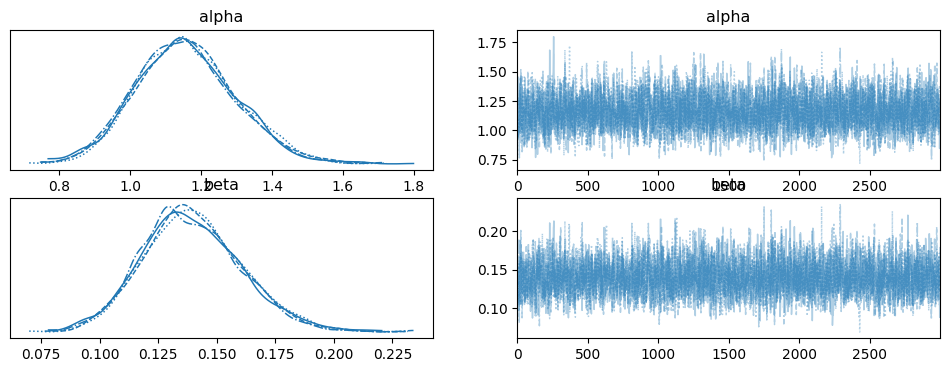

In [ ]:
with pm.Model() as model:
    # Define priors
    alpha = pm.Gamma('alpha', alpha=8, beta=1)  # Añadir beta para la distribución Gamma
    beta = pm.Gamma('beta', alpha=2, beta=1)    # Añadir beta para la distribución Gamma

    # Define likelihood
    likelihood = pm.Gamma('likelihood', alpha=alpha, beta=beta, observed=precios_filtrados)

    idata = pm.sample(3000, tune=1000)

pm.plot_trace(idata)
